# Logistic Regression

In machine learning, logistic regression, or logit model, is a regression model that is typically used for binary classification tasks. For instance, to predict if an email is a spam or not, or to distinguish whether a grid of pixel intensities represents a “0” digit or a “1” digit. 

Formally, given a dataset $X=[x_1|x_2|\cdots|x_n]^T$ of $n$ elements, we want to predict each corresponding label $y_i\in\{0,1\}$ from $x_i$. In the two examples mentioned above, $x_i$ is either the contents of each email, or the pixel intensities of each given figure. In the first case, $y_i=1$ represents the email is spam, and $y_i=0$ otherwise. In the second case, $y_i$ is simply the digit value.


## Model specification:

In logistic regression we use a hypothesis class to try to predict the probability that a given example belongs to the “1” class versus the probability that it belongs to the “0” class. Specifically, we will try to learn the conditional probability represented in the form:

$P(y=1|x)=h_{\beta}(x)=\frac{1}{1+\exp(−\beta^{\top}x)}\equiv \sigma(\beta^{\top}x),$

$P(y=0|x)=1−P(y=1|x)=1−h_{\beta}(x).$

The value $\beta^{\top}x$ is the linear prediction we get from the model $\beta$ and a data point $x$. The larger this value is, the more possible $x$ belongs to category $1$. To "squash" this value to $[0,1]$ range so that we could interpret this value as probability, we use this function $\sigma(z)\equiv 1+\exp(−z)$, also called the "sigmoid" or "logistic" function. Our goal is to search for a value of $\beta$ so that the probability $P(y=1|x)=h_{\beta}(x)$ is large when $x$ belongs to the "1" class and small when $x$ belongs to the "0" class (so that $\Pr(y=0|x)$ is large). For a set of training examples with binary labels $\{(x(i),y(i)):i=1,\cdots,m\}$ the following cost function measures how well a given $h_{\beta}$ does this:

$J(\beta)=−\sum_i(y_i\log(h_{\beta}(x_i))+(1−y_i)\log(1−h_{\beta}(x_i))).$



## Data handling
We use a dataset from Kaggle competition [Santander Customer Satisfaction](https://www.kaggle.com/c/santander-customer-satisfaction). In this example, the labels are in the last "TARGET" column, and each sample has 368 features with no further descriptions. We first conduct logistic regression on this task by using mxnet's NDArray.

In [2]:
import mxnet as mx
import os
import urllib
def getData(fname):
    data=[]
    label=[]
    firstline=True
    for line in file(fname):
        if (firstline):
            firstline=False
            continue
        tks = line.strip().split(',')
        data.append([float(i) for i in tks[1:-2]]) # omit the first column of user ID.
        label.append(int(tks[-1]))
    return mx.nd.array(data),mx.nd.array(label)
if not os.path.exists('train.csv'):
    urllib.urlretrieve('https://www.kaggle.com/c/santander-customer-satisfaction/download/train.csv.zip', 'train.csv')
if not os.path.exists('test.csv'):
    urllib.urlretrieve('https://www.kaggle.com/c/santander-customer-satisfaction/download/test.csv.zip', 'test.csv')
X_train,y_train=getData('train.csv')
X_train.shape

(76020L, 368L)

### Preprocess
For simpler calculations, we add an all one feature to each sample to avoid the use of constant: $\beta^T x + b \Rightarrow [\beta, b]^T[x,1]$. MXNet NDArray has the concatenate attribute designed for this task.

We reshape the labels "y_train" as a nx1 2D array for the sake of mxnet ndarray multiplication. (Otherwise y_train will only have one dimension and won't be able to multiply with a 2D NDArray)

In [3]:
n,p = X_train.shape
n,p
n=int(n)
p=int(p)
X_train=mx.nd.concatenate([X_train.T,mx.nd.ones((1,n))]).T # add the terms for constant
p+=1
n,p
y_train=y_train.reshape((n,1))

## Optimization
### Step-by-step implementation by NDArray
Logistic regression maximizes the log-likelihood function. In order to conduct gradient descent on $J(\beta)$, we compute its gradient $g$ first:
$g\equiv\nabla_{\beta}J(\beta)=\sum_ix_i(h_{\beta}(x_i)−y_i)= \sum_ix_i\big(\frac{1}{1+\exp(−\beta^{\top}x_i)}-y_i\big)=X^T(1./(1+\exp(-X\beta))-y)$, where $./$ is coordinate-wise division.

With the help of MXNet NDArray, we could compute the gradience step by step as follows: 

In [4]:
# initialization
beta=mx.nd.zeros((p,1))
# multiplication
predy=mx.nd.dot(X_train,beta)
# exponential
exppredy=mx.nd.exp(-predy)
# entry-wise division
h=mx.nd.divide(mx.nd.ones((n,1)),exppredy+1)
tmp=h-y_train
g=mx.nd.dot(mx.nd.transpose(X_train),tmp)
g

<NDArray 369x1 @cpu(0)>

In order to avoid overfitting, we add an $\ell_2$ regularization $\alpha\|\beta\|_2^2$ to the loss function $J(\beta)$, therefore in the gradient descent step, we do:
$\beta\leftarrow \beta-2\alpha\beta-g=(1-2\alpha)\beta-\eta g$, where $\eta$ is the learning rate.

Therefore the whole training process of logistic regression becomes:

In [5]:
from sklearn.metrics import roc_auc_score
def train(X_train, y_train):
    beta=mx.nd.zeros((p,1))
    itr = 20
    alpha=0.01
    learn_rate = 1./n
    predy=mx.nd.dot(X_train,beta)
    for i in range(itr):
        exppredy=mx.nd.exp(-predy)
        tmp=mx.nd.divide(mx.nd.ones((n,1)),exppredy+1)-y_train
        g=mx.nd.dot(mx.nd.transpose(X_train),tmp)
        beta=beta*(1-2*alpha)-learn_rate*g
        predy=mx.nd.dot(X_train,beta)
        auc=roc_auc_score(y_train.asnumpy(), predy.asnumpy())
        print "iter %d: training auc: %.4f"%(i, auc)
    return beta
beta=train(X_train,y_train)

iter 0: training auc: 0.6496
iter 1: training auc: 0.6499
iter 2: training auc: 0.6502
iter 3: training auc: 0.6506
iter 4: training auc: 0.6510
iter 5: training auc: 0.6515
iter 6: training auc: 0.6523
iter 7: training auc: 0.6539
iter 8: training auc: 0.6562
iter 9: training auc: 0.6575
iter 10: training auc: 0.6581
iter 11: training auc: 0.6601
iter 12: training auc: 0.6616
iter 13: training auc: 0.6624
iter 14: training auc: 0.6630
iter 15: training auc: 0.6653
iter 16: training auc: 0.7220
iter 17: training auc: 0.7267
iter 18: training auc: 0.7275
iter 19: training auc: 0.7287


### Symbol manipulation
Another important object in MXNet is Symbol provided by mxnet.symbol, or mxnet.sym for short. 
A symbol represents a multi-output symbolic expression. They are composited by operators, such as simple matrix operations (e.g. “+”), or a neural network layer (e.g. convolution layer). Details can be found in http://mxnet.io/tutorials/python/symbol.html.

Therefore, after using the NDArray to design the algorithm for logistic regression, we could also implement the whole process using mxnet.sym. 

We copy the function "train", but only change all the "mx.nd" to "mx.sym". Notice mxnet.symbol inherits the operations supported by mx.ndarray, and functions in a symbolic way. 

In [6]:
def train(X_train, y_train):
    beta=mx.sym.zeros((p,1))
    itr = 20
    alpha=0.01
    learn_rate = 1./n
    predy=mx.sym.dot(X_train,beta)
    for i in range(itr):
        exppredy=mx.sym.exp(-predy)
        tmp=mx.sym.ones((n,1))/(exppredy+1)-y_train
        g=mx.sym.dot(mx.sym.transpose(X_train),tmp)
        beta=beta*(1-2*alpha)-learn_rate*g
        predy=mx.sym.dot(X_train,beta)
    return beta

#### Bind with data and evaluate:
After defining the train function, we can run it and get a symbolic output.
Notice this whole process only declares computation, we need to bind with data to run.
In the following, we bind with the same data as before and get the same result we got using NDArray: 

In [7]:
X_train_sym = mx.sym.Variable('X_train')
y_train_sym = mx.sym.Variable('y_train')
beta_sym=train(X_train_sym,y_train_sym)
ex=beta_sym.bind(ctx=mx.cpu(), args={'X_train':X_train, 'y_train':y_train})
ex.forward()
beta=ex.outputs[0]
auc=roc_auc_score(y_train.asnumpy(), mx.nd.dot(X_train,beta).asnumpy())
print "Final training auc: %.4f"%(auc)

Final training auc: 0.7287


### Module auto differentiation
Instead of computing the gradient manually, mxnet.symbol actually supports auto differentiation. 
We first define a single layered network with a fully connected layer and logistic regression output, and show how mxnet.mod.Module supports train, predict and evaluate automatically. 

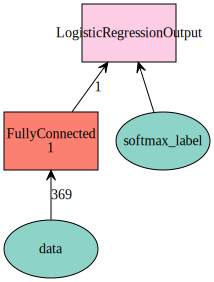

In [10]:
import mxnet as mx
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=1)
net = mx.sym.LogisticRegressionOutput(data=net, name='softmax')
shape = {"data" : (1, p)}
mx.viz.plot_network(symbol=net, shape=shape)

In [11]:
mod = mx.mod.Module(symbol=net)
train_iter=mx.io.NDArrayIter(data=X_train,label=y_train,batch_size=1)
print(train_iter.provide_data)
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
# init parameters
mod.init_params(initializer=mx.init.Xavier(magnitude=0.01))

# init optimizer
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', 1./n), ))

# use accuracy as the metric
metric = mx.metric.create('acc')

# train one epoch, i.e. going over the data iter one pass
for batch in train_iter:
    mod.forward(batch, is_train=True)       # compute predictions
    mod.update_metric(metric, batch.label)  # accumulate prediction accuracy
    mod.backward()                          # compute gradients
    mod.update()                            # update parameters using SGD
    
# training error
print(metric.get())

[DataDesc[data,(1, 369L),<type 'numpy.float32'>,NCHW]]
('accuracy', 0.9474217311233886)


Finally, similar to the linear regression, logistic regression is easily trained by calling the fit function.

In [12]:
mod = mx.mod.Module(symbol=net)
mod.fit(train_iter, eval_data=train_iter, optimizer='sgd',optimizer_params={'learning_rate':1./n},eval_metric='mse',num_epoch=20)
for batch in train_iter:
    mod.update_metric(metric,batch.label)
print(metric.get())

('accuracy', 0.9539265982636148)


To compare the result from what we got by manually training the logistic regression model, we again output the accuracy measured by roc auc score:

In [13]:
print(roc_auc_score(y_train.asnumpy(),mod.predict(train_iter).asnumpy()))

0.70665938057
